In [87]:
import nibabel
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import time
from pprint import pprint
import cv2
from glob import glob
import os
import random
import gc
import shutil
from PIL import Image
import skimage
import sklearn.metrics
import logging
logging.basicConfig(level=logging.DEBUG)
!pip install pqdm
from pqdm.processes import pqdm

In [88]:
## Make slices
volumes = glob('/kaggle/input/liver-tumor-segmentation/volume*/*.nii')
volumes2 = glob('/kaggle/input/liver-tumor-segmentation-part-2/volume*/*.nii')
volumes.extend(volumes2)

In [89]:
dataset = {}
segmentation_root = '/kaggle/input/liver-tumor-segmentation/segmentations/'

for v in volumes:
    base = os.path.basename(v)
    segmentation = os.path.join(segmentation_root, base.replace('volume', 'segmentation'))
    if os.path.exists(segmentation):
        dataset[v] = segmentation

In [90]:
ZEROS = np.zeros((512, 512))
def liver_and_tumor_png(liver, mask, liver_root, mask_root):
    liver_base = os.path.basename(liver).replace('.nii', '')
    mask_base  = os.path.basename(mask).replace('.nii', '')

    liver_folder_name = os.path.join(liver_root.replace('.nii', ''), liver_base)
    if os.path.exists(liver_folder_name):
        shutil.rmtree(liver_folder_name)
    os.mkdir(liver_folder_name)
    
    mask_folder_name = os.path.join(mask_root.replace('.nii', ''), mask_base)
    if os.path.exists(mask_folder_name):
        shutil.rmtree(mask_folder_name)
    os.mkdir(mask_folder_name)

    liver_img = nibabel.load(liver).get_fdata()
    mask_img2 = nibabel.load(mask).get_fdata()

    liver_img = np.clip(liver_img, -45, 105)
    mask_img = np.clip(mask_img2, 0, 1).astype(np.uint8) * 255
    tumor_img = (mask_img2 > 1).astype(np.uint8) * 255
    
    for d in range(0, liver_img.shape[2]):
        liver_png_file_name = os.path.join(liver_folder_name, f"{d}.png")
        tumor_png_file_name = os.path.join(mask_folder_name, f"{d}.png")
        
        windowed_slice = np.uint8(skimage.exposure.rescale_intensity(
            liver_img[:, :, d], in_range='image', out_range=(0, 255)
        ))
    
        tumor_mask = tumor_img[:, :, d]
        final_img = windowed_slice & mask_img[:, :, d]
    
        if np.all(final_img == ZEROS):
            continue

        skimage.io.imsave(liver_png_file_name, final_img, check_contrast=False)
        skimage.io.imsave(tumor_png_file_name, tumor_mask, check_contrast=False)
    
    gc.collect()

In [91]:
# !rm -fr /kaggle/working/masks_png
# !rm -fr /kaggle/working/images_png
# !rm -fr /kaggle/working/predict_png

!mkdir /kaggle/working/masks_png
!mkdir /kaggle/working/images_png
!mkdir /kaggle/working/predict_png
# nii_to_png("/kaggle/input/liver-tumor-segmentation/segmentations/segmentation-28.nii", '/kaggle/working/masks_png')

mkdir: cannot create directory ‘/kaggle/working/masks_png’: File exists
mkdir: cannot create directory ‘/kaggle/working/images_png’: File exists
mkdir: cannot create directory ‘/kaggle/working/predict_png’: File exists


In [92]:
IMG_ROOT = '/kaggle/working/images_png'
MASK_ROOT = '/kaggle/working/masks_png'
TOTAL_IMAGES = 5000

if not os.path.exists(IMG_ROOT):
    os.mkdir(IMG_ROOT)

if not os.path.exists(MASK_ROOT):
    os.mkdir(MASK_ROOT)

def process(args):
    logging.debug(f"Generating data {args}")
    dat, seg = args
    liver_and_tumor_png(dat, seg, IMG_ROOT, MASK_ROOT)
# _ = pqdm(dataset.items(), process, n_jobs=4)

In [93]:
def segment_tumor(Ipath, dst_path):
#     if os.path.exists(dst_path):
#         return
    
    I = skimage.io.imread(Ipath)
    a, b = skimage.filters.threshold_multiotsu(I)
    if b < 200:
        T2 = np.zeros_like(I)
    else:
        T = ((a <= I) & (I <= b))
        T0 = skimage.morphology.area_closing(T, area_threshold=64)
        T2 = skimage.morphology.remove_small_objects(T0, connectivity=8, min_size=64)
        T2 = np.uint8(skimage.exposure.rescale_intensity(T2, in_range='image', out_range=(0, 255)))
    return skimage.io.imsave(dst_path, T2, check_contrast=False)

In [94]:
all_images = sorted(glob('images_png/**/*.png'))[:TOTAL_IMAGES]

def segment_all(image):
    dst = image.replace('volume', 'segmentation').replace('images_png', 'predict_png')
    if not os.path.exists(os.path.dirname(dst)):
        os.mkdir(os.path.join(os.path.dirname(dst)))
    segment_tumor(image, dst)

results = pqdm(all_images, segment_all, n_jobs=16)

QUEUEING TASKS | :   0%|          | 0/5000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5000 [00:00<?, ?it/s]

In [95]:
prediction = sorted(glob('./predict_png/**/*.png'))[:TOTAL_IMAGES]
masks = sorted(glob('./masks_png/**/*.png'))[:TOTAL_IMAGES]
print(len(prediction), len(all_images))

5000 5000


In [96]:
def get_area(I):
    t, Ith = cv2.threshold(I, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(Ith, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in contours]
    return sum(areas)

In [105]:
scores = []
AREA_MIN = 2000

for ground, pred in zip(tqdm(masks), prediction):
    G = (cv2.imread(ground, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)
    P = (cv2.imread(pred, cv2.IMREAD_GRAYSCALE) > 64).astype(np.uint8)

    if get_area(P) >= AREA_MIN:
        scores.append(sklearn.metrics.jaccard_score(G.flatten(), P.flatten()))

/tmp/ipykernel_47/2102439698.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ground, pred in zip(tqdm(masks), prediction):


  0%|          | 0/5000 [00:00<?, ?it/s]

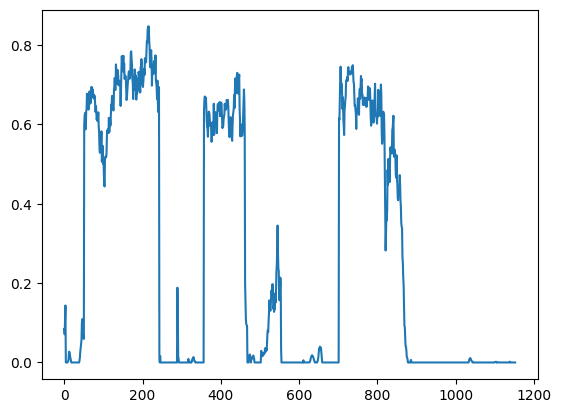

In [106]:
plt.plot(scores)

In [107]:
np.mean(scores)

0.26532558213576246

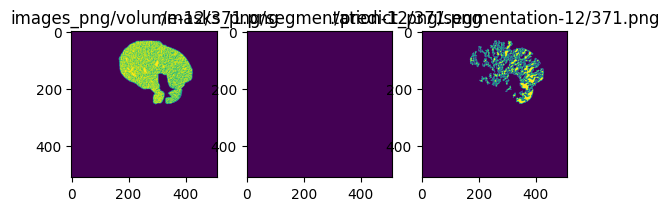

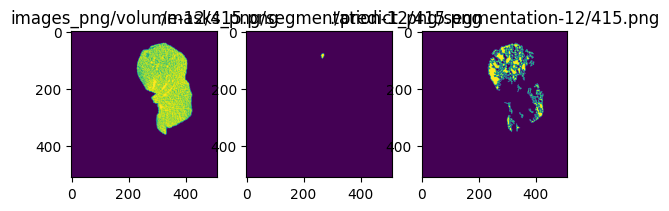

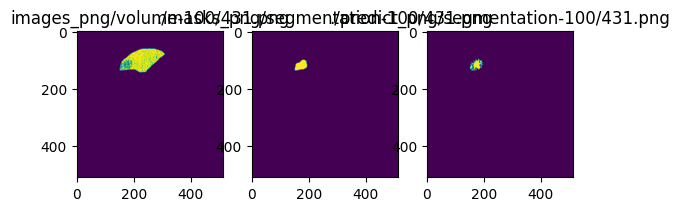

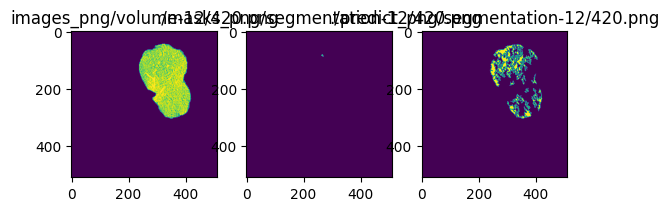

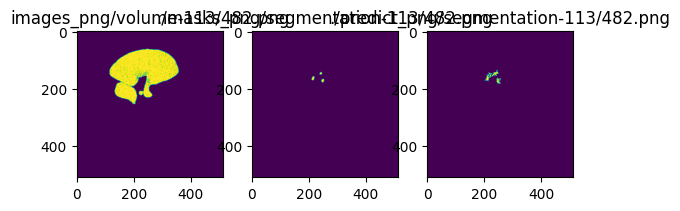

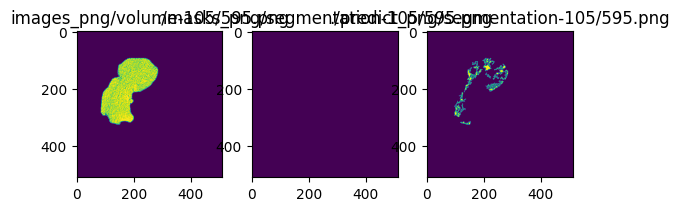

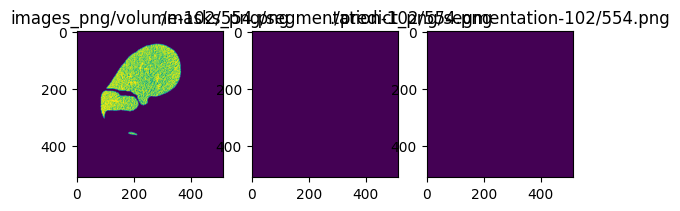

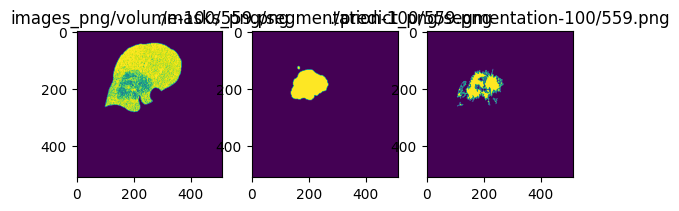

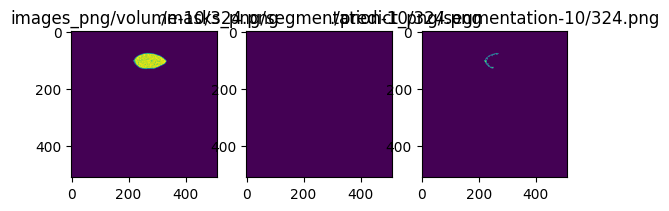

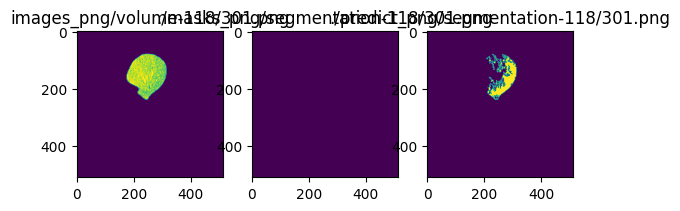

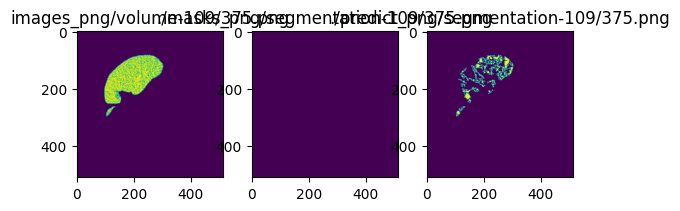

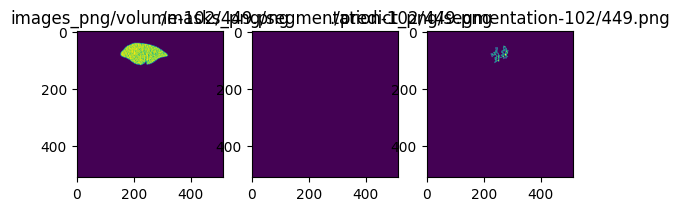

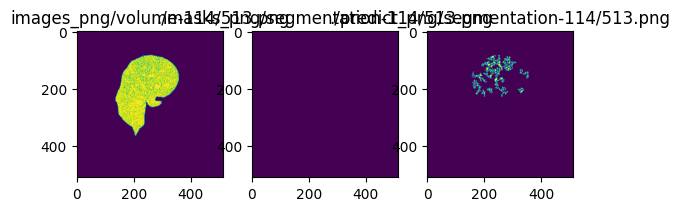

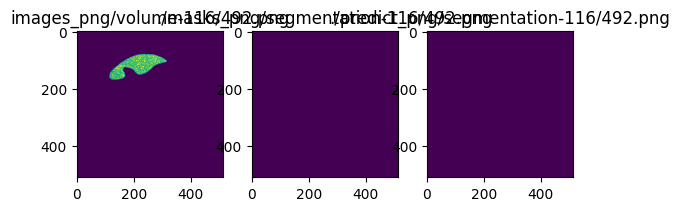

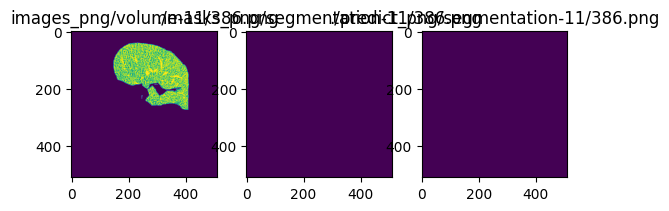

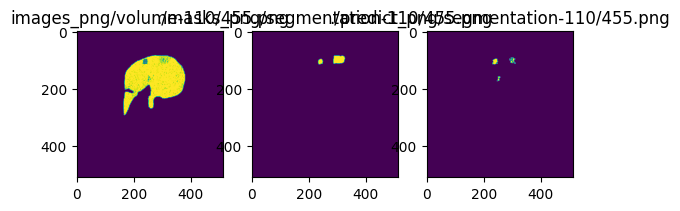

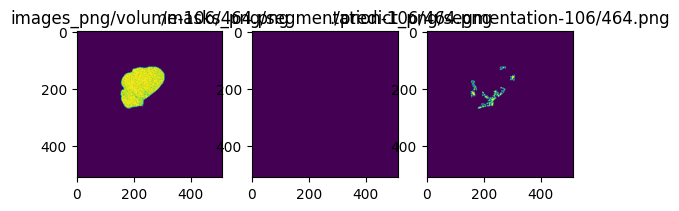

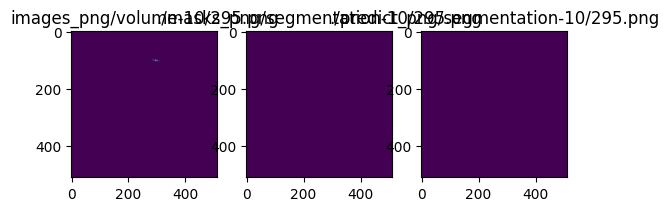

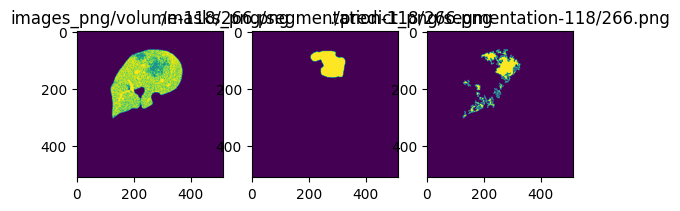

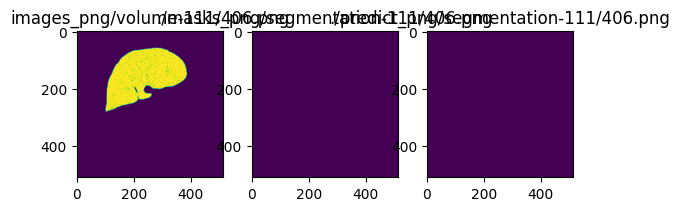

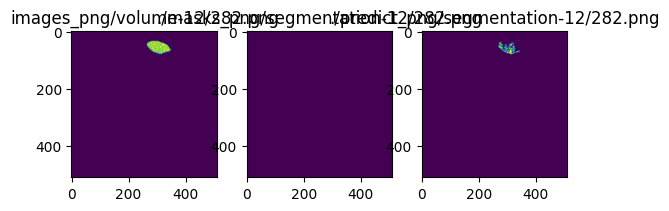

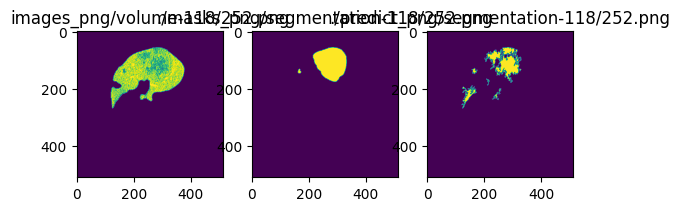

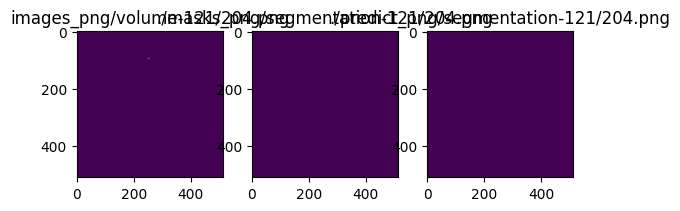

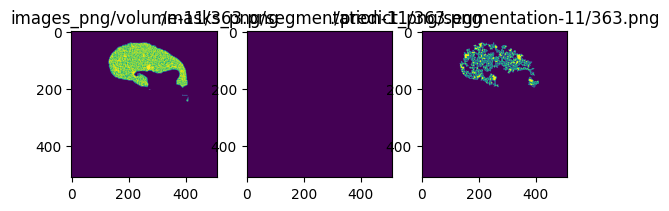

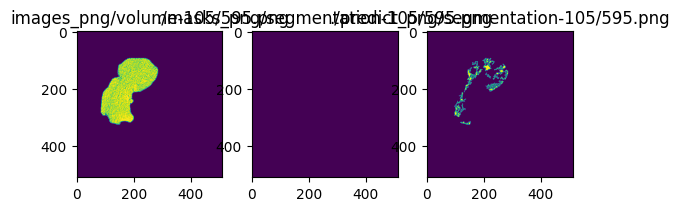

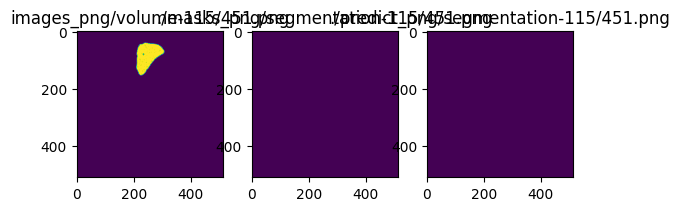

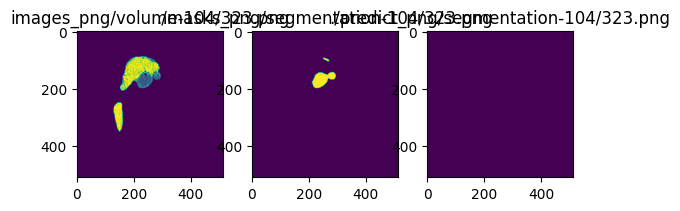

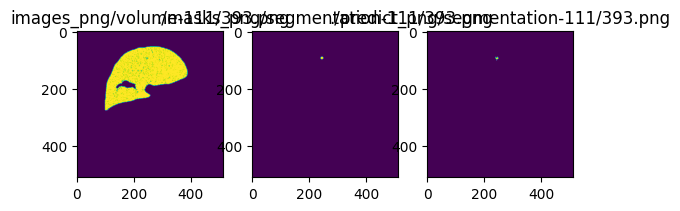

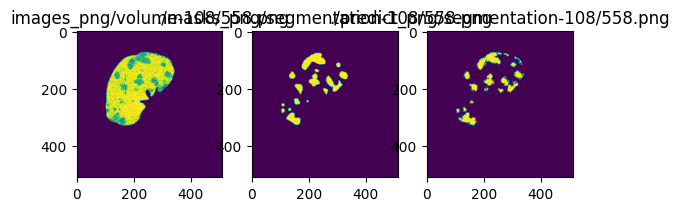

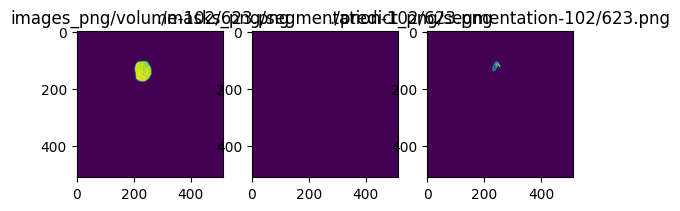

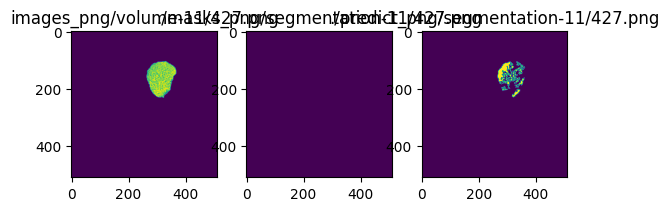

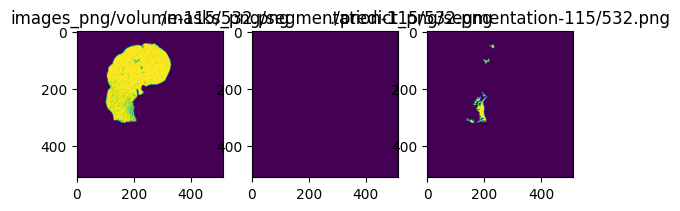

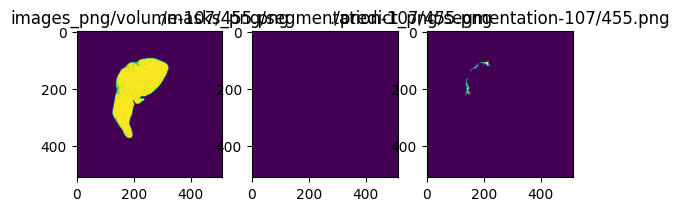

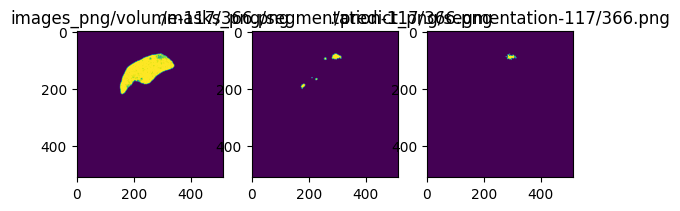

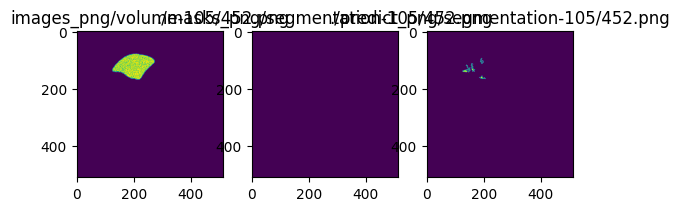

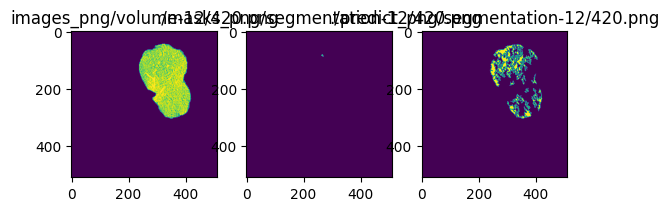

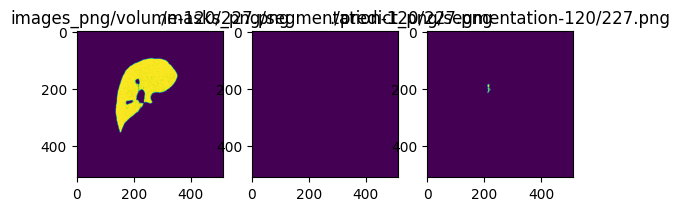

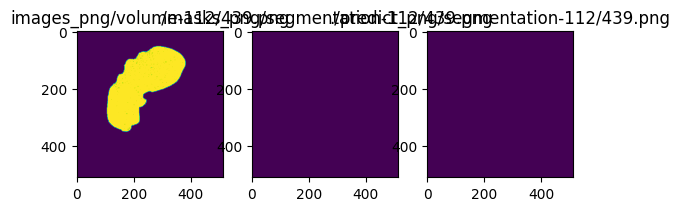

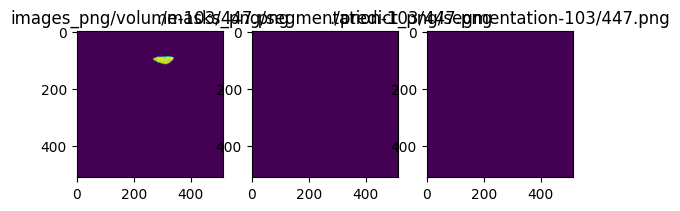

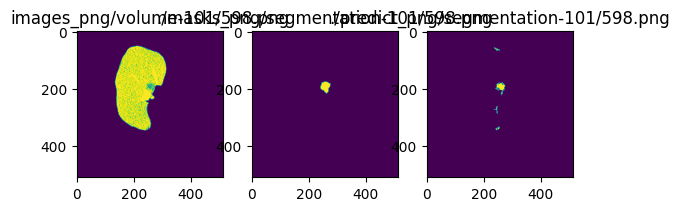

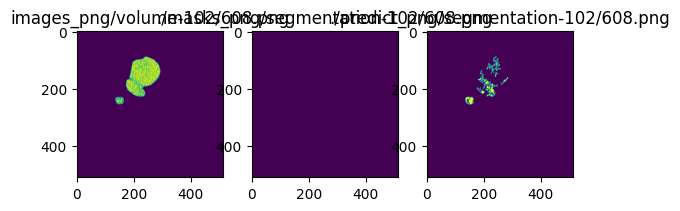

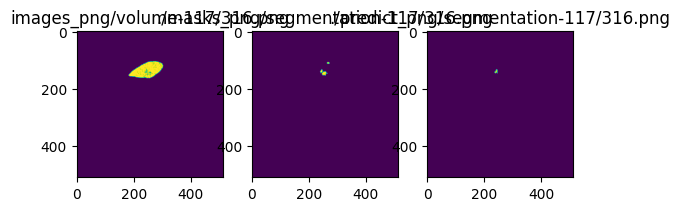

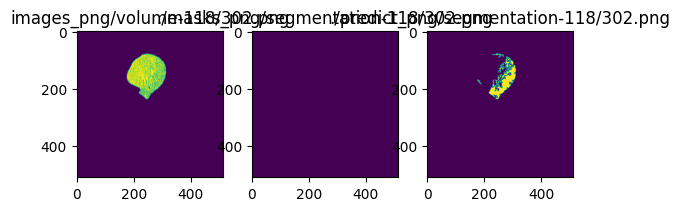

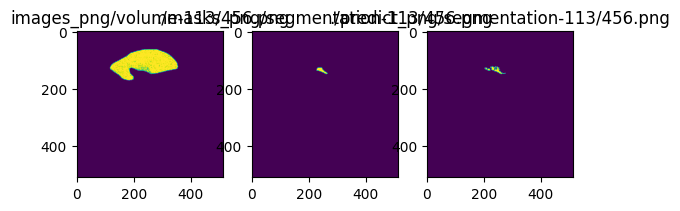

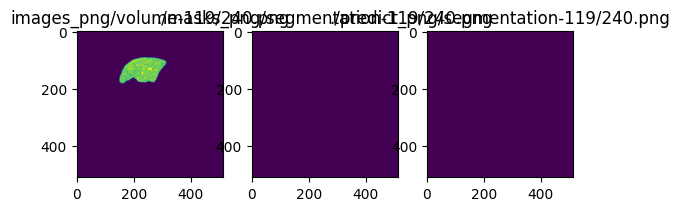

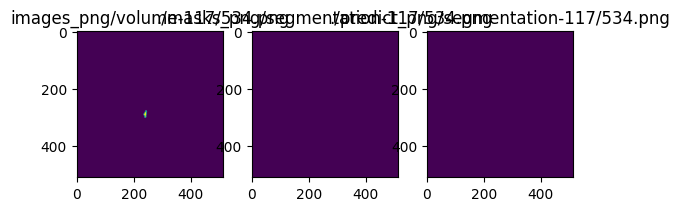

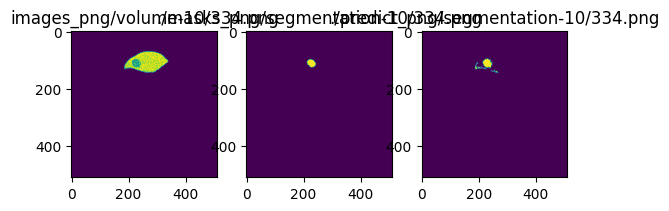

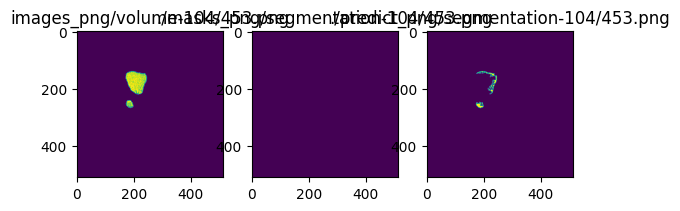

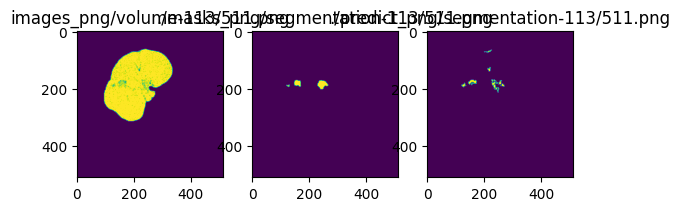

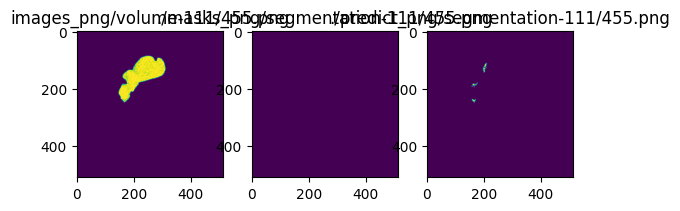

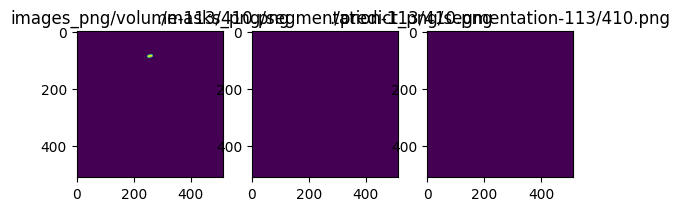

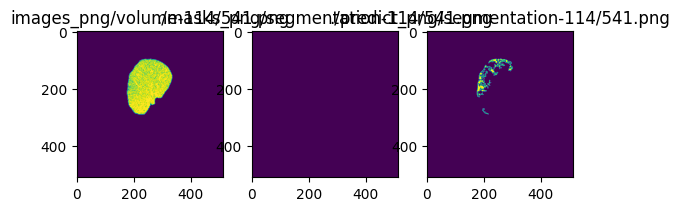

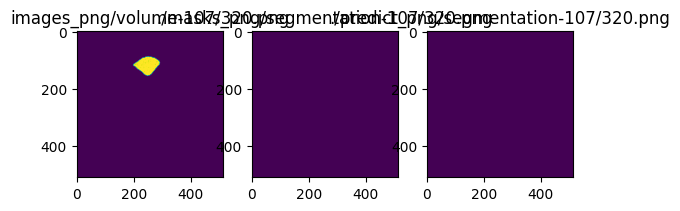

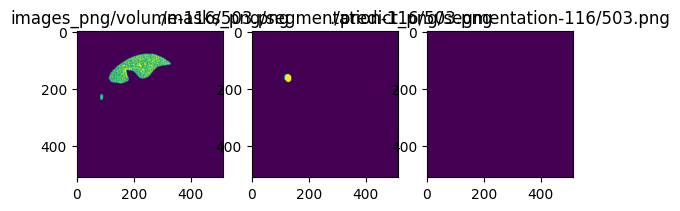

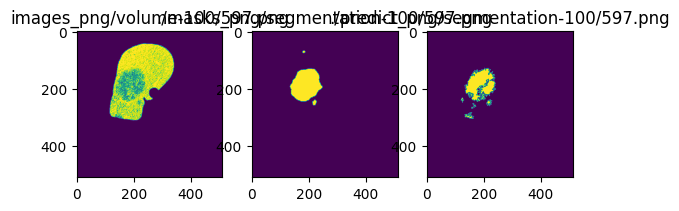

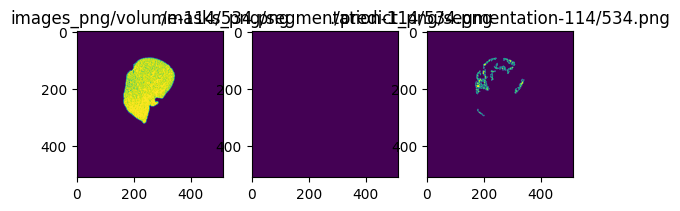

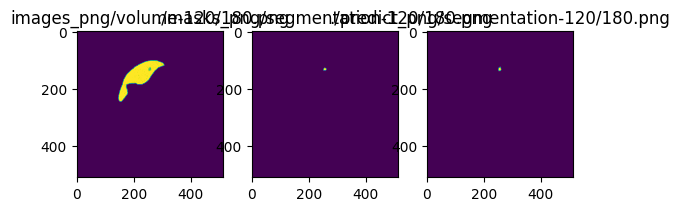

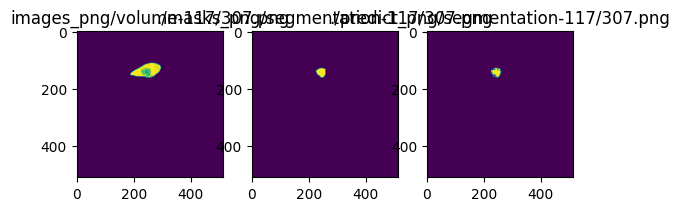

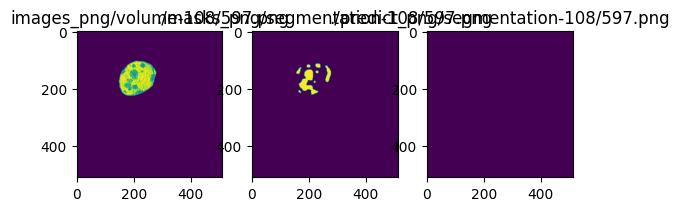

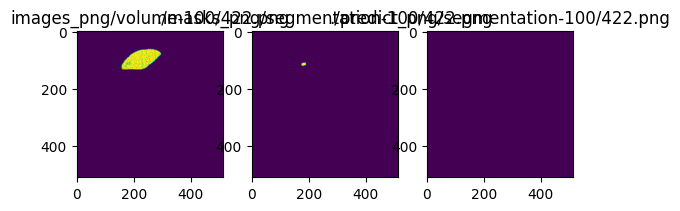

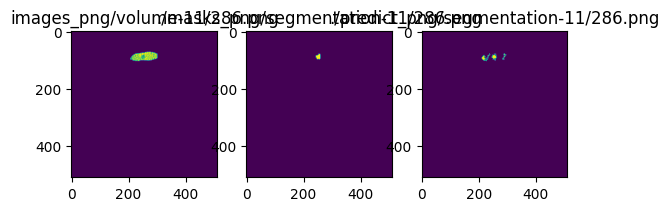

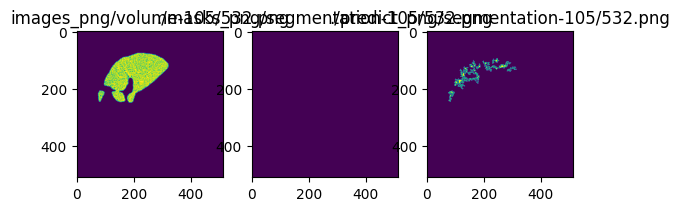

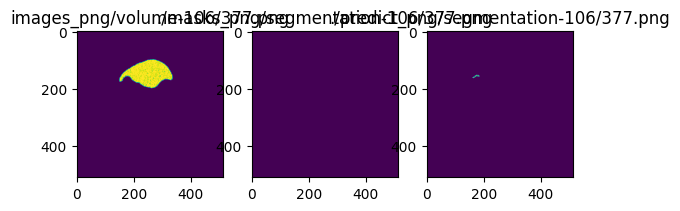

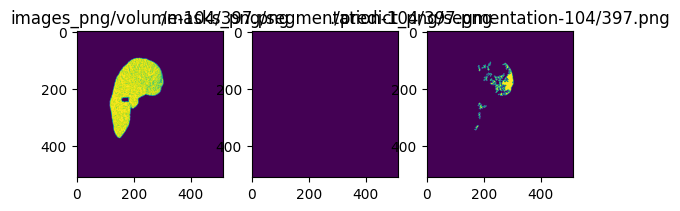

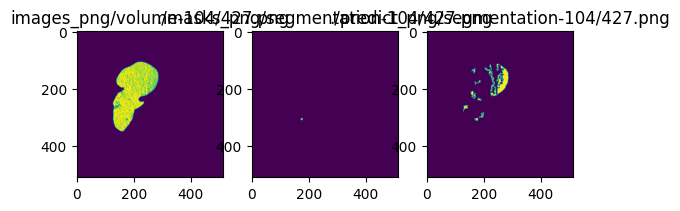

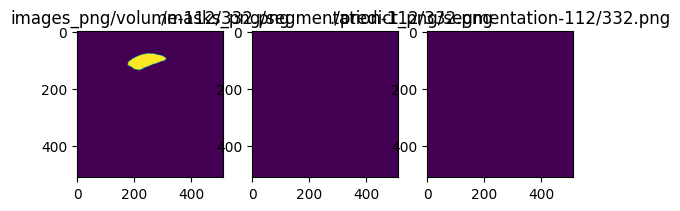

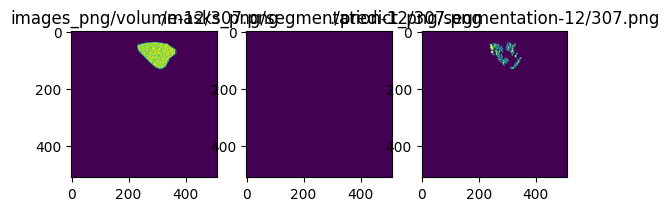

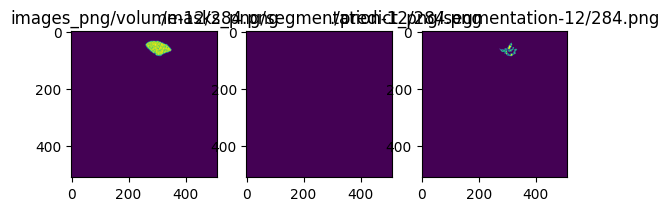

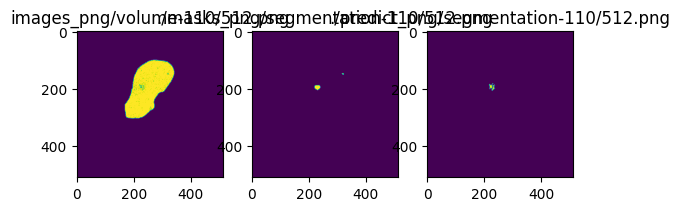

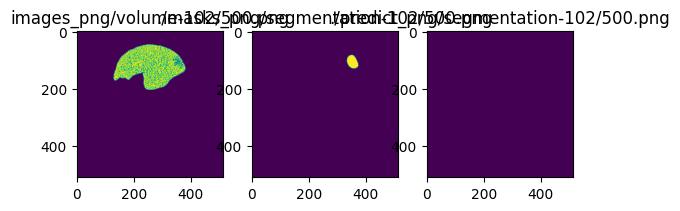

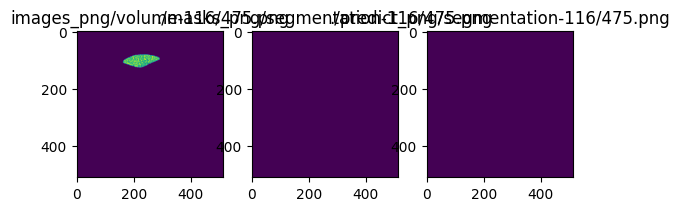

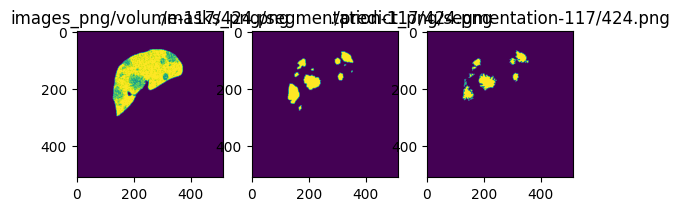

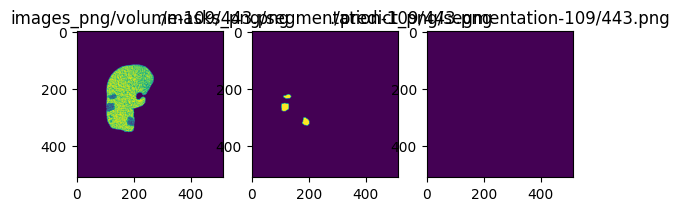

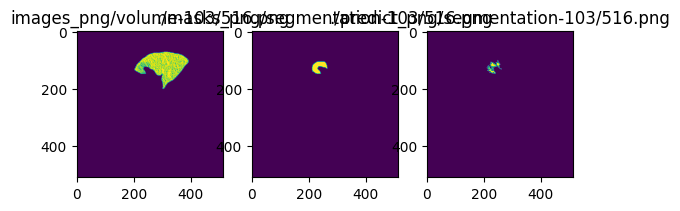

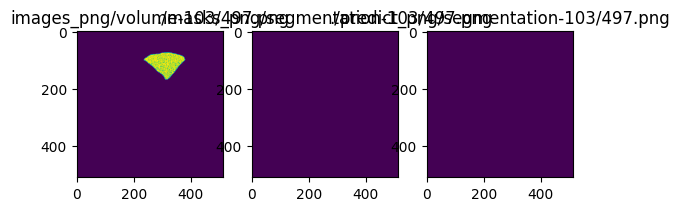

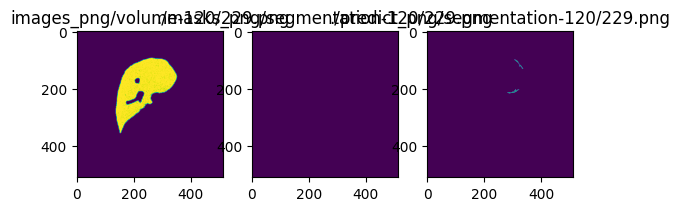

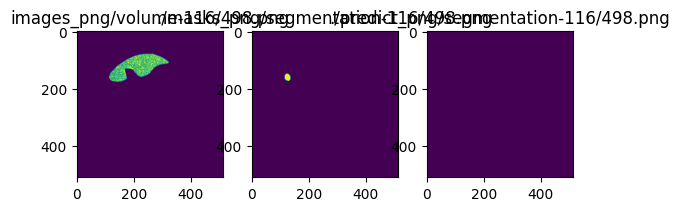

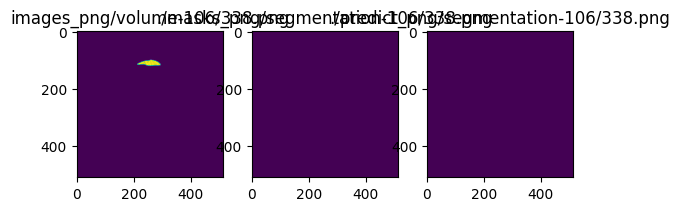

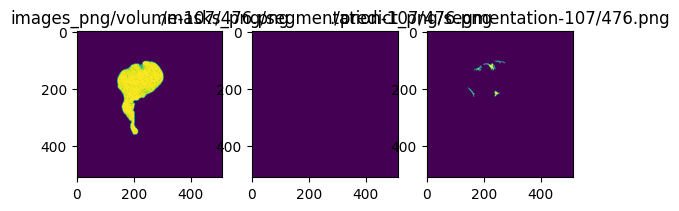

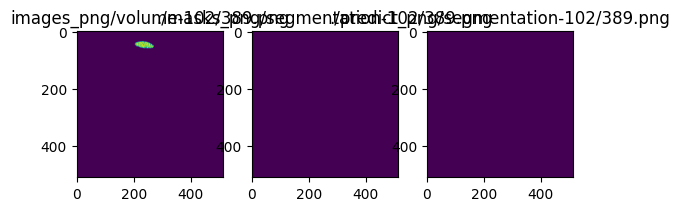

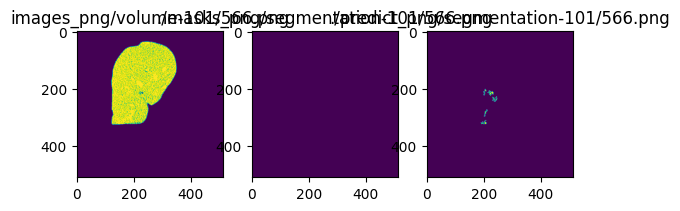

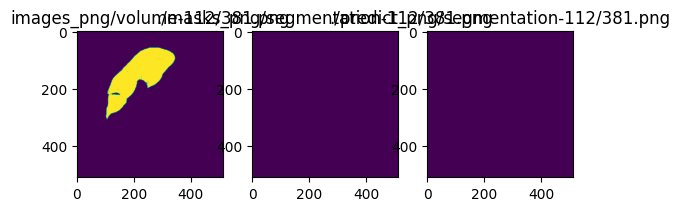

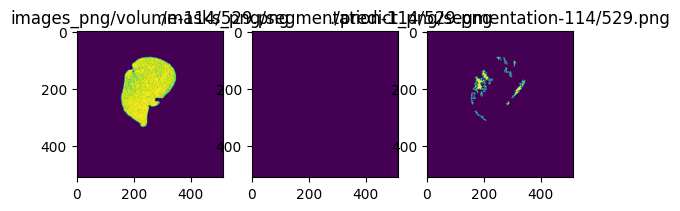

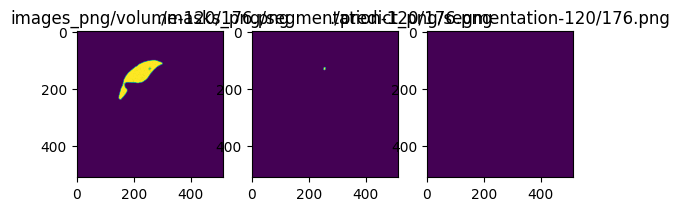

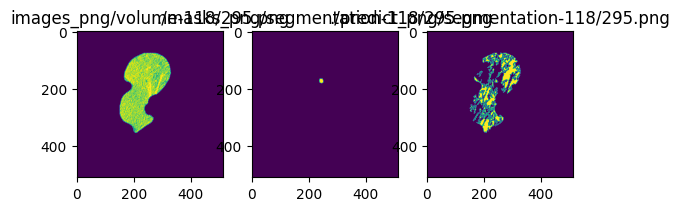

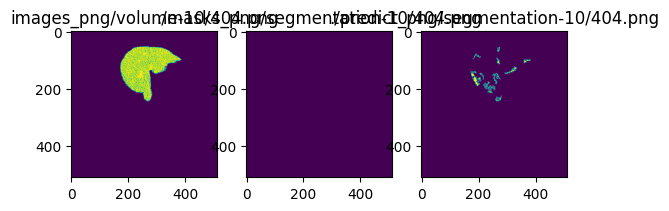

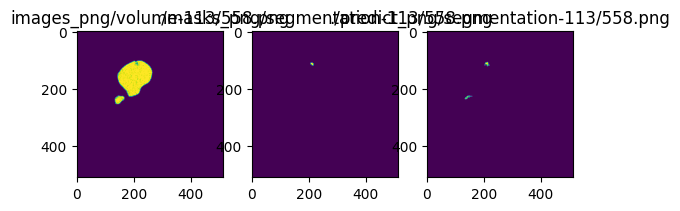

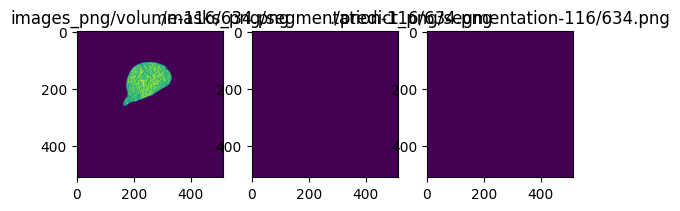

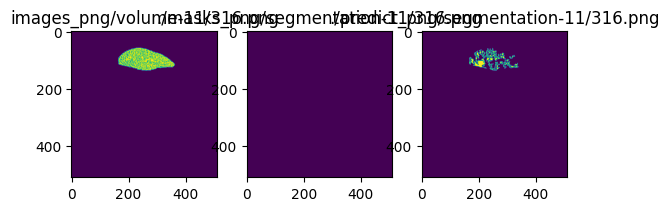

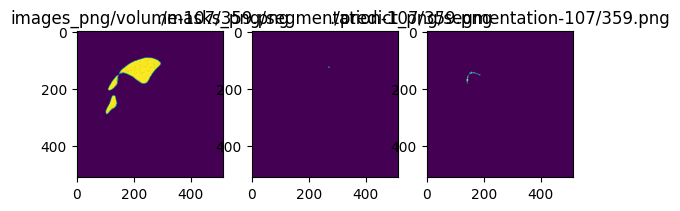

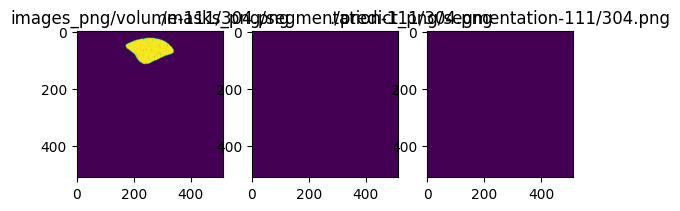

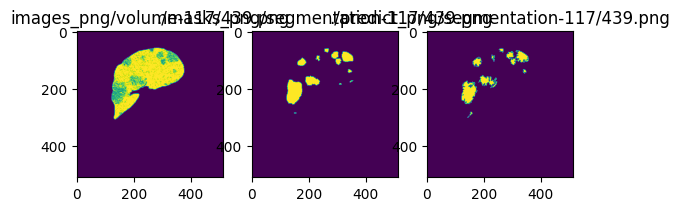

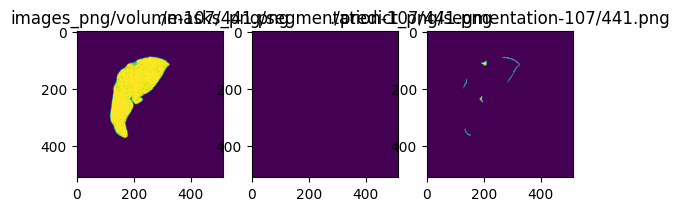

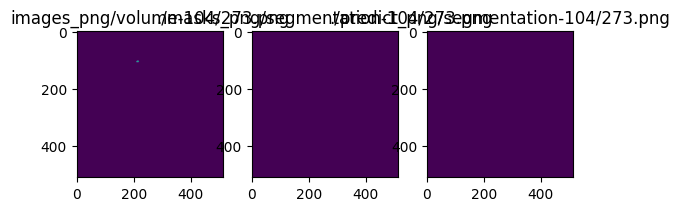

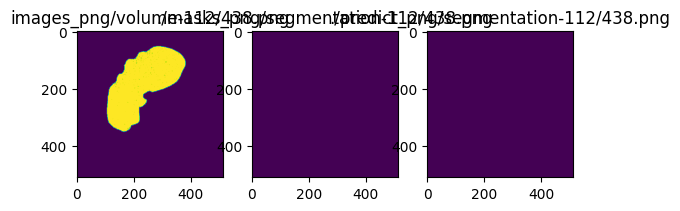

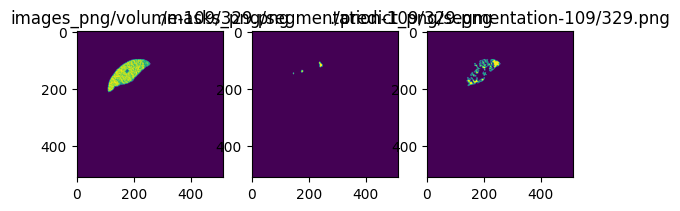

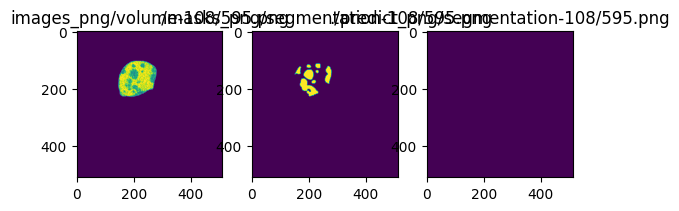

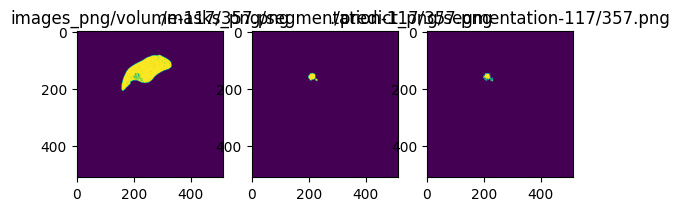

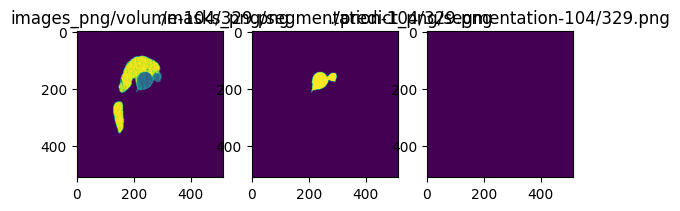

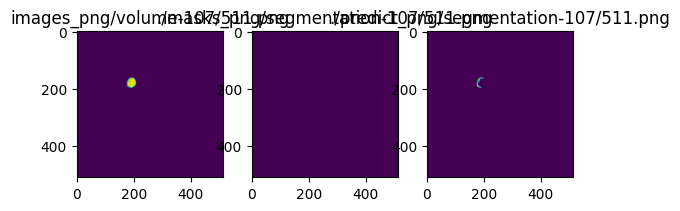

In [108]:
rnds = np.random.randint(0, high=TOTAL_IMAGES-1, size=(100, 1))
for (r, ) in rnds:
    plt.subplot(1, 3, 1)
    plt.imshow(Image.open(all_images[r]))
    plt.title(all_images[r])
    
    plt.subplot(1, 3, 2)
    plt.imshow(Image.open(masks[r]))
    plt.title(masks[r])
    
    plt.subplot(1, 3, 3)
    plt.imshow(Image.open(prediction[r]))
    plt.title(prediction[r])
    plt.show()

0.6425772420660755

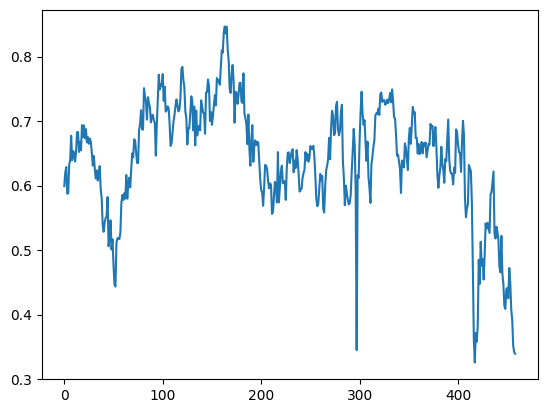

In [110]:
scores = np.array(scores)
scores2 = scores[scores > 0.3]
plt.plot(scores2)
np.mean(scores2)

In [101]:
# 102, 557
# /kaggle/working/images_png/volume-49/141.png
# /kaggle/working/masks_png/segmentation-21/431.png
# /kaggle/working/predict_png/segmentation-114/431.png

array([ 79, 198])

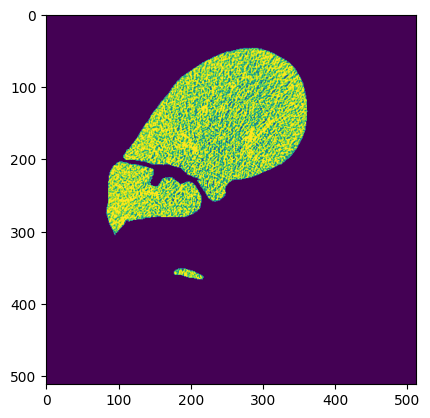

In [102]:
I = '/kaggle/working/images_png/volume-102/557.png'
I1 = skimage.io.imread(I)
plt.imshow(I1)
skimage.filters.threshold_multiotsu(I1)

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


ValueError: After discretization into bins, the input image has only 2 different values. It cannot be thresholded in 3 classes. If there are more unique values before discretization, try increasing the number of bins (`nbins`).

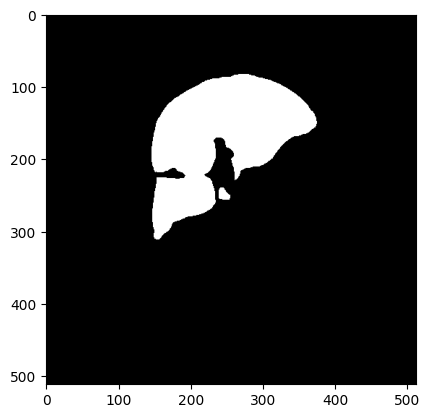

In [103]:
I = '/kaggle/working/images_png/volume-119/269.png'
I2 = skimage.io.imread(I)
Ie = skimage.morphology.binary_erosion(I2)
plt.imshow(Ie, cmap='gray')
skimage.filters.threshold_multiotsu(Ie)

In [ ]:
_ = plt.hist(I1.reshape(-1, 1), bins=256, histtype='step')

In [ ]:
_ = plt.hist(I2.reshape(-1, 1), bins=256, histtype='step')

In [ ]:
I = '/kaggle/working/images_png/volume-101/479.png'
I3 = skimage.io.imread(I)
plt.imshow(I3, cmap='gray')
skimage.filters.threshold_multiotsu(I3)

In [ ]:
_ = plt.hist(I3.reshape(-1, 1), bins=256, histtype='step')

In [ ]:
I = '/kaggle/working/images_png/volume-119/269.png'
I2 = skimage.io.imread(I)
Ie = skimage.morphology.white_tophat(I2)
plt.imshow(I2 - Ie, cmap='gray')
skimage.filters.threshold_multiotsu(I2 - Ie)

In [ ]:
It = I2 - Ie
plt.imshow((It > 81) & (It < 183))